In [1]:
import tensorflow as tf
from tensorflow import keras
import random
import copy
import matplotlib.pyplot as plt
import time
from threading import Thread
import os
from IPython.core.display import Video
%matplotlib inline

2022-07-15 11:54:49.765527: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-15 11:54:49.765550: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# generate data

In [2]:
class Cell:
    def __init__(self, x, y, dead=False):
        self.x = x
        self.y = y
        self.isDead = dead
        
    def key(self):
        return f"{self.x},{self.y}"
    
    def scan(self, cells):
        self.alive = {}
        self.dead = {}
        
        # scan 8 surrounding cells
        for y_offset in range(-1, 2):
            for x_offset in range(-1, 2):
                if not (x_offset == 0 and y_offset == 0):
                    x = self.x + x_offset
                    y = self.y + y_offset
                    key = f"{x},{y}"
                    # find the neighbor
                    if key in cells:
                        self.alive[key] = cells[key]
                    # create a dead cell
                    else:
                        dead_cell = Cell(x, y, True)
                        self.dead[key] = dead_cell
                        
    
    # assumes this cell has already been scanned
    # returns alive cell if new state alive else nothing
    def tick(self):
        # Any live cell with two or three live neighbours survives
        if not self.isDead:
            alive_count = len(self.alive)
            if alive_count == 2 or alive_count == 3:
                return self
        
        # Any dead cell with three live neighbours becomes a live cell
        else:
            if len(self.alive) == 3:
                self.isDead = False
                return self
        
        # All other live cells die in the next generation
        # Similarly, all other dead cells stay dead
        return None

In [3]:
class GameOfLife:
    def __init__(self, count, width, height):
        # generate cells
        self.width = width
        self.height = height
        self.cells = {}
        self.id = ("%032x" % random.getrandbits(128))[0:6]
        
        while len(self.cells) < count:
            half_width, half_height = int(width/2), int(height/2)
            x = random.randint(-half_width, half_width)
            y = random.randint(-half_height, half_height)
            cell = Cell(x, y)
            self.cells[cell.key()] = cell
    
    def to_pixels(self, half_width, half_height):
        # convert cells to pixels
        pixels = []
        for y in range(-half_height, half_height):
            column = []
            for x in range(-half_width, half_width):
                color = 1 if f"{x},{y}" in self.cells else 0
                column.append(color)
            pixels.append(column)
        return pixels
    
    def update(self, width=None, height=None):
        self.tick()
        self.draw(width, height)
    
    def draw(self, width=None, height=None):
        width = width if width else self.width
        height = height if height else self.height
        half_width, half_height = int(width/2), int(height/2)
        
        data = self.to_pixels(half_width, half_height)
        plt.imshow(data, interpolation='nearest')
        
        # adjust graph view
        plt.xlim([-0.5, width-0.5])
        plt.xlim([-0.5, height-0.5])
        
    def tick(self):
        # create a new state
        new_cells = {}
        
        # consolidate dead cells
        dead_cells = {}
        for key, cell in self.cells.items():
            # update cell
            cell.scan(self.cells)
            
            # aggregate new dead cells
            for dead_key, dead_cell in cell.dead.items():
                if (not dead_key in dead_cells):
                    dead_cells[dead_key] = dead_cell
            
            # find next state
            next_cell = cell.tick()
            if next_cell:
                new_cells[key] = next_cell
        
        # tick dead cells
        for key, cell in dead_cells.items():
            # update cell
            cell.scan(self.cells)
            
            # find next state
            next_cell = cell.tick()
            if next_cell:
                new_cells[key] = next_cell
                
        # update scene
        self.cells = new_cells

In [4]:
# config
screen_size = 4
spawn_size = 100
frame = 0
sim = None

def sim_dir_name():
    global spawn_size, sim
    return f"output/{spawn_size}-{sim.id}"

def sim_file_name(file_name):
    return f"{sim_dir_name()}/{file_name}.png"

def new_game():
    global sim, frame, screen_size, spawn_size
    frame = 0
    min_fill, max_fill = 0.25, 0.75
    max_count = spawn_size*spawn_size
    count = random.randint(max_count*min_fill, max_count*max_fill)
    # start the game
    sim = GameOfLife(count, spawn_size, spawn_size)
    # create save destination
    os.mkdir(sim_dir_name())
    return sim

def save_fig(frame):
    path = sim_file_name(str(frame).zfill(3))
    plt.savefig(path)

def next_frame(alt_size = None):
    global frame, screen_size, sim
    size = alt_size if alt_size else screen_size
    save_fig(frame)
    sim.update(size, size)
    frame += 1

In [5]:
# start new game
sim = new_game()
print(f"Instance: {sim.id}")

Instance: 556816


3/10
4/10
5/10
6/10
7/10
8/10
9/10
10/10
11/10


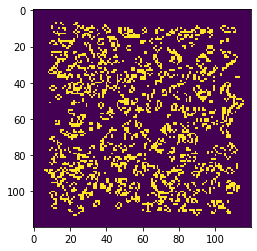

In [6]:
# practice run manually in batches
practice_runs = 10

next_milestone = 1
milestone_dist = 0.1
run_profit = milestone_dist * practice_runs
for i in range(1, practice_runs+1):
    if (i > next_milestone * run_profit):
        next_milestone += 1
        print(f"{i+1}/{practice_runs}")
    sim.tick()

sim.draw(spawn_size+20, spawn_size+20)

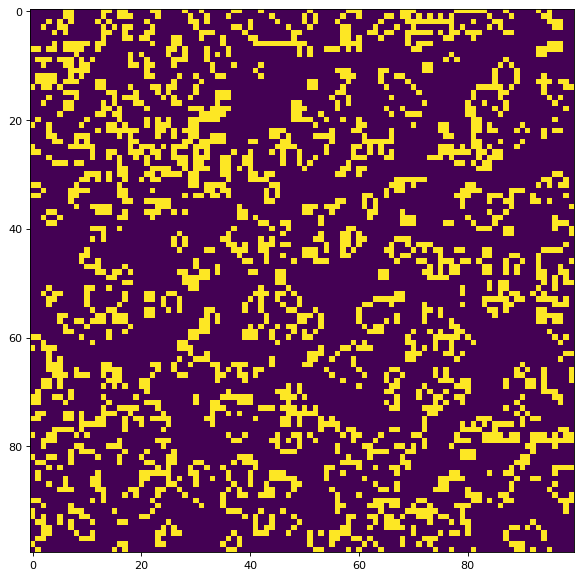

In [7]:
plt.figure(figsize=(12,9), dpi=80)

sim.draw(spawn_size, spawn_size)

# manually step through a simulation
next_frame(spawn_size)

Rendering: 4.00%
Rendering: 4.04%
Rendering: 4.08%
Rendering: 4.12%
Rendering: 4.16%
Rendering: 4.20%
Rendering: 4.25%
Rendering: 4.29%
Rendering: 4.33%
Rendering: 4.37%
Rendering: 4.42%
Rendering: 4.46%
Rendering: 4.51%
Rendering: 4.55%
Rendering: 4.60%
Rendering: 4.64%
Rendering: 4.69%
Rendering: 4.74%
Rendering: 4.78%
Rendering: 4.83%
Rendering: 4.88%
Rendering: 4.93%
Rendering: 4.98%
Rendering: 5.03%
Rendering: 5.08%
Rendering: 5.13%
Rendering: 5.18%
Rendering: 5.23%
Rendering: 5.29%
Rendering: 5.34%
Rendering: 5.39%
Rendering: 5.45%
Rendering: 5.50%
Rendering: 5.55%
Rendering: 5.61%
Rendering: 5.67%
Rendering: 5.72%
Rendering: 5.78%
Rendering: 5.84%
Rendering: 5.90%
Rendering: 5.96%
Rendering: 6.02%
Rendering: 6.08%
Rendering: 6.14%
Rendering: 6.20%
Rendering: 6.26%
Rendering: 6.32%
Rendering: 6.39%
Rendering: 6.45%
Rendering: 6.51%
Rendering: 6.58%
Rendering: 6.64%
Rendering: 6.71%
Rendering: 6.78%
Rendering: 6.85%
Rendering: 6.91%
Rendering: 6.98%
Rendering: 7.05%
Rendering: 7.1

KeyboardInterrupt: 

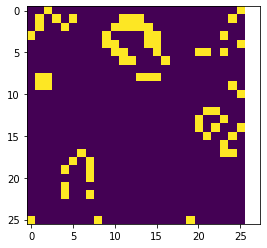

In [8]:
next_milestone = 1
milestone_dist = 0.001

# render frames
while screen_size < spawn_size:
    progress = screen_size/spawn_size
    if (progress > next_milestone * milestone_dist):
        next_milestone += 1
        progress_text = "{0:.2%}".format(progress)
        print(f"Rendering: {progress_text}")
    
    screen_size *= 1.01
    next_frame(screen_size)

In [ ]:
# convert images to video
file_pattern = sim_file_name("%03d")
video_file = f"{sim_dir_name()}.mp4"
os.system(f"ffmpeg -framerate 24 -i {file_pattern} -pix_fmt yuv420p {video_file}")
print(video_file)

In [ ]:
Video(video_file)

# setup data